## Initial setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
print(tf.__version__)
# tensorflow version used is 2.7.0
import torch
print(torch.__version__)
# torch version used is 1.10+cu111

2.8.0
1.10.0+cu111


In [ ]:
!nvidia-smi

Sat Feb 19 13:59:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Other imports
! pip install tensorflow_addons
! pip install tensorflow_io

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras as tfkeras
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import Image, display

import zipfile
import concurrent.futures

# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

## Dataset gathering and preparation

In [ ]:
Imagenet_images_train = list(paths.list_images("/content/drive/MyDrive/TEM image datasets/2022-1000-ImageNet"))
train_images_directory_select = np.random.choice(Imagenet_images_train, 832, replace=False)
print(len(Imagenet_images_train))
print(len(train_images_directory_select))

1000
832


In [ ]:
CEM_images_train = list(paths.list_images("/content/drive/MyDrive/TEM image datasets/2021-CEM500K/jpg"))
train_images_directory_select = np.random.choice(CEM_images_train, 832, replace=False)
print(len(CEM_images_train))
print(len(train_images_directory_select))

10000
832


In [ ]:
%cd /content/drive/MyDrive/peptide-morphology-classification-project/

/content/drive/MyDrive/peptide-morphology-classification-project


In [ ]:
training_batch_size = 64
test_batch_size = 32

imageSize=224

In [ ]:
# Augmentation utilities (differs from the original implementation)
# Adapted from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A) 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        

        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)

        # Random crop always
        sample = self._random_apply(self._random_crop, sample, p=1.0)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)

        return sample

    def _random_crop(self, x):
        
        # distance from left to right, from bottom to top
        l = tf.random.uniform([], minval=int(imageSize * 0.25), maxval=int(imageSize * 0.5), dtype=tf.int32)             # 25 as min bound, so that the cropped images are not too small
        # l = int(0.5 * imageSize)                                                                              # use this line if the crop box size is constant

        # lower left corner
        y1 = tf.random.uniform([], minval=0, maxval= imageSize - 1 - l, dtype=tf.int32)
        x1 = tf.random.uniform([], minval=0, maxval= imageSize - 1 - l, dtype=tf.int32)
        
        x = tf.image.crop_to_bounding_box(x, y1, x1, l, l)
        x = tf.image.resize(x, size=[imageSize, imageSize])
        return x

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        # x = tf.image.random_brightness(x, max_delta=0.2*s)                 
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[imageSize, imageSize])

    return image

In [ ]:
# Create TensorFlow dataset for training
train_ds = tf.data.Dataset.from_tensor_slices(train_images_directory_select)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Initiate our self-supervised model

In [ ]:
Resnet50_transfer = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(imageSize, imageSize, 3), 
    pooling=None,
)

Resnet50_transfer.trainable = True

In [ ]:
# Architecture for resnet as base architecture
def get_resnet_self_supervise_model(hidden_1, hidden_2, hidden_3):
    base_model = Resnet50_transfer
    base_model.trainable = True
    inputs = Input((imageSize, imageSize, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)                                        
    projection_1 = Activation("relu")(projection_1)
    projection_1 = BatchNormalization(epsilon=0.001)(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_2 = BatchNormalization(epsilon=0.001)(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)
    projection_3 = BatchNormalization(epsilon=0.001)(projection_3)

    resnet_model = Model(inputs, projection_3)
    
    return resnet_model

## Training self-supervised model

In [ ]:
#### use this train_step block for Simclr implementation

tf.config.run_functions_eagerly(True)

@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        projections_1_original = model(xis)
        projections_2_original = model(xjs)

        # simclr derivatives uses layer norm
        # normalize projection feature vectors            along the feature dimension, this is a l2_norm
        projections_1 = tf.math.l2_normalize(projections_1_original, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2_original, axis=1)
        similarities = (tf.matmul(projections_1, projections_2, transpose_b=True) / temperature)

        # the temperature-scaled similarities are used as logits for cross-entropy
        contrastive_labels = tf.range(training_batch_size)
        loss = criterion(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
#### use this train_step block for Barlow-Twins implementation

tf.config.run_functions_eagerly(True)

@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        projections_1_original = model(xis)
        projections_2_original = model(xjs)

        # batchnorm for barlow twins
        # use these two lines when doing mini-batch gradient descent
        projections_1 = (projections_1_original - tf.reduce_mean(projections_1_original, axis=0)) / tf.math.reduce_std(projections_1_original, axis=0)
        projections_2 = (projections_2_original - tf.reduce_mean(projections_2_original, axis=0)) / tf.math.reduce_std(projections_2_original, axis=0)

        # use these two lines when doing stochastic gradient descent (i.e. batch size = 1)
        # projections_1 = projections_1_original
        # projections_2 = projections_2_original

        # the cross correlation of image representations should be the identity matrix

        feature_dim = tf.cast(tf.shape(projections_1)[1], tf.float32)
        cross_correlation = (tf.matmul(projections_1, projections_2, transpose_a=True) / training_batch_size)
        target_cross_correlation = tf.eye(feature_dim)
        squared_errors = (target_cross_correlation - cross_correlation) ** 2

        # invariance loss = average diagonal error
        # redundancy reduction loss = average off-diagonal error
        invariance_loss = (tf.reduce_sum(squared_errors * tf.eye(feature_dim)) / feature_dim)
        redundancy_reduction_loss = tf.reduce_sum(squared_errors * (1 - tf.eye(feature_dim))) / (feature_dim * (feature_dim - 1))

        # use redundancy_redunction_weight of 0.005 from the paper, not a sensitive parameter
        loss = invariance_loss + 0.005 * redundancy_reduction_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
def train_model(model, dataset, optimizer, criterion,
                 temperature, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    epoch = 1
    for k in tqdm(range(epochs)):
      i = 0
      for image_batch in dataset:
          a = data_augmentation(image_batch)
          b = data_augmentation(image_batch)

          loss = train_step(a, b, model, optimizer, criterion, temperature)
          step_wise_loss.append(loss)
          i += 1
          print("batch: {} loss: {:.5f}".format(i, np.mean(step_wise_loss)))

      epoch_wise_loss.append(np.mean(step_wise_loss))
      if epoch % 20 == 0:
        model.save_weights('barlow_ImageNet_batch%i_project128_64_1024_seed%i.h5' % (training_batch_size, random_seed))
        print("epoch: {} loss: {:.5f}".format(epoch, np.mean(step_wise_loss)))
      epoch += 1
          

    return epoch_wise_loss, model

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 

# the learning rate decay schedule in the original implementation of SimCLR and Barlow-Twins
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.2, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

training_model = get_resnet_self_supervise_model(128, 64, 1024)

epoch_wise_loss, resnet_model  = train_model(training_model, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

plt.plot(epoch_wise_loss)
plt.title("training loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

batch: 1 loss: 0.57619
batch: 2 loss: 0.43121
batch: 3 loss: 0.45222
batch: 4 loss: 0.39469
batch: 5 loss: 0.38681
batch: 6 loss: 0.33074
batch: 7 loss: 0.35192
batch: 8 loss: 0.34164
batch: 9 loss: 0.35104
batch: 10 loss: 0.36822
batch: 11 loss: 0.36665
batch: 12 loss: 0.35966


  0%|          | 1/200 [11:33<38:21:06, 693.80s/it]

batch: 13 loss: 0.33729
batch: 1 loss: 0.32755
batch: 2 loss: 0.34130
batch: 3 loss: 0.33533
batch: 4 loss: 0.32271
batch: 5 loss: 0.31440
batch: 6 loss: 0.31166
batch: 7 loss: 0.29918
batch: 8 loss: 0.28848
batch: 9 loss: 0.27715
batch: 10 loss: 0.27190
batch: 11 loss: 0.28531
batch: 12 loss: 0.27678


  1%|          | 2/200 [22:50<37:36:52, 683.90s/it]

batch: 13 loss: 0.27652
batch: 1 loss: 0.27942
batch: 2 loss: 0.28107
batch: 3 loss: 0.27381
batch: 4 loss: 0.26927
batch: 5 loss: 0.26277
batch: 6 loss: 0.25918
batch: 7 loss: 0.25793
batch: 8 loss: 0.25574
batch: 9 loss: 0.24996
batch: 10 loss: 0.24518
batch: 11 loss: 0.24362
batch: 12 loss: 0.23837


  2%|▏         | 3/200 [34:09<37:17:54, 681.60s/it]

batch: 13 loss: 0.23610
batch: 1 loss: 0.23580
batch: 2 loss: 0.23282
batch: 3 loss: 0.22809
batch: 4 loss: 0.22476
batch: 5 loss: 0.22062
batch: 6 loss: 0.21746
batch: 7 loss: 0.21734
batch: 8 loss: 0.21505
batch: 9 loss: 0.21278
batch: 10 loss: 0.21072
batch: 11 loss: 0.20777
batch: 12 loss: 0.20842


  2%|▏         | 4/200 [45:34<37:11:09, 683.01s/it]

batch: 13 loss: 0.20911
batch: 1 loss: 0.20676
batch: 2 loss: 0.20360
batch: 3 loss: 0.20137
batch: 4 loss: 0.19841
batch: 5 loss: 0.19752
batch: 6 loss: 0.19467
batch: 7 loss: 0.19474
batch: 8 loss: 0.19202
batch: 9 loss: 0.18932
batch: 10 loss: 0.18666
batch: 11 loss: 0.18378
batch: 12 loss: 0.18168


  2%|▎         | 5/200 [57:01<37:04:26, 684.44s/it]

batch: 13 loss: 0.17976
batch: 1 loss: 0.17924
batch: 2 loss: 0.17720
batch: 3 loss: 0.17774
batch: 4 loss: 0.17523
batch: 5 loss: 0.17427
batch: 6 loss: 0.17216
batch: 7 loss: 0.17020
batch: 8 loss: 0.16820
batch: 9 loss: 0.16731
batch: 10 loss: 0.16708
batch: 11 loss: 0.16545
batch: 12 loss: 0.16392


  3%|▎         | 6/200 [1:08:44<37:13:16, 690.70s/it]

batch: 13 loss: 0.16309
batch: 1 loss: 0.16115
batch: 2 loss: 0.16031
batch: 3 loss: 0.15966
batch: 4 loss: 0.15798
batch: 5 loss: 0.15774
batch: 6 loss: 0.15649
batch: 7 loss: 0.15519
batch: 8 loss: 0.15473
batch: 9 loss: 0.15320
batch: 10 loss: 0.15180
batch: 11 loss: 0.15050
batch: 12 loss: 0.14895


  4%|▎         | 7/200 [1:20:29<37:16:23, 695.25s/it]

batch: 13 loss: 0.14764
batch: 1 loss: 0.14642
batch: 2 loss: 0.14534
batch: 3 loss: 0.14427
batch: 4 loss: 0.14284
batch: 5 loss: 0.14209
batch: 6 loss: 0.14105
batch: 7 loss: 0.14056
batch: 8 loss: 0.13948
batch: 9 loss: 0.13827
batch: 10 loss: 0.13721
batch: 11 loss: 0.13623
batch: 12 loss: 0.13502
batch: 13 loss: 0.13429


  4%|▍         | 8/200 [1:32:51<37:52:23, 710.12s/it]

batch: 1 loss: 0.13313
batch: 2 loss: 0.13211
batch: 3 loss: 0.13158
batch: 4 loss: 0.13055
batch: 5 loss: 0.12949
batch: 6 loss: 0.12854
batch: 7 loss: 0.12752
batch: 8 loss: 0.12647
batch: 9 loss: 0.12582
batch: 10 loss: 0.12489
batch: 11 loss: 0.12422
batch: 12 loss: 0.12546


  4%|▍         | 9/200 [1:44:56<37:55:59, 714.97s/it]

batch: 13 loss: 0.12449
batch: 1 loss: 0.12360
batch: 2 loss: 0.12267
batch: 3 loss: 0.12226
batch: 4 loss: 0.12221
batch: 5 loss: 0.12178
batch: 6 loss: 0.12156
batch: 7 loss: 0.12094
batch: 8 loss: 0.12008
batch: 9 loss: 0.11936
batch: 10 loss: 0.11854
batch: 11 loss: 0.11779
batch: 12 loss: 0.11741
batch: 13 loss: 0.11754


  5%|▌         | 10/200 [1:57:18<38:10:26, 723.29s/it]

batch: 1 loss: 0.11689
batch: 2 loss: 0.11614
batch: 3 loss: 0.11538
batch: 4 loss: 0.11458
batch: 5 loss: 0.11444
batch: 6 loss: 0.11371
batch: 7 loss: 0.11293
batch: 8 loss: 0.11231
batch: 9 loss: 0.11165
batch: 10 loss: 0.11144
batch: 11 loss: 0.11155
batch: 12 loss: 0.11085


  6%|▌         | 11/200 [2:09:18<37:54:46, 722.15s/it]

batch: 13 loss: 0.11027
batch: 1 loss: 0.11002
batch: 2 loss: 0.10948
batch: 3 loss: 0.10879
batch: 4 loss: 0.10941
batch: 5 loss: 0.10988
batch: 6 loss: 0.11054
batch: 7 loss: 0.11070
batch: 8 loss: 0.11029
batch: 9 loss: 0.10982
batch: 10 loss: 0.10929
batch: 11 loss: 0.10888
batch: 12 loss: 0.10856


  6%|▌         | 12/200 [2:21:13<37:36:00, 720.00s/it]

batch: 13 loss: 0.10822
batch: 1 loss: 0.10772
batch: 2 loss: 0.10748
batch: 3 loss: 0.10699
batch: 4 loss: 0.10653
batch: 5 loss: 0.10756
batch: 6 loss: 0.10694
batch: 7 loss: 0.10635
batch: 8 loss: 0.10574
batch: 9 loss: 0.10526
batch: 10 loss: 0.10480
batch: 11 loss: 0.10450
batch: 12 loss: 0.10398


  6%|▋         | 13/200 [2:32:56<37:07:57, 714.85s/it]

batch: 13 loss: 0.10352
batch: 1 loss: 0.10295
batch: 2 loss: 0.10258
batch: 3 loss: 0.10211
batch: 4 loss: 0.10166
batch: 5 loss: 0.10121
batch: 6 loss: 0.10090
batch: 7 loss: 0.10036
batch: 8 loss: 0.10023
batch: 9 loss: 0.09988
batch: 10 loss: 0.09948
batch: 11 loss: 0.09897
batch: 12 loss: 0.09883


  7%|▋         | 14/200 [2:44:39<36:45:24, 711.42s/it]

batch: 13 loss: 0.09841
batch: 1 loss: 0.09804
batch: 2 loss: 0.09791
batch: 3 loss: 0.09746
batch: 4 loss: 0.09700
batch: 5 loss: 0.09752
batch: 6 loss: 0.09725
batch: 7 loss: 0.09687
batch: 8 loss: 0.09680
batch: 9 loss: 0.09636
batch: 10 loss: 0.09590
batch: 11 loss: 0.09586
batch: 12 loss: 0.09547


  8%|▊         | 15/200 [2:56:25<36:27:56, 709.60s/it]

batch: 13 loss: 0.09537
batch: 1 loss: 0.09499
batch: 2 loss: 0.09454
batch: 3 loss: 0.09417


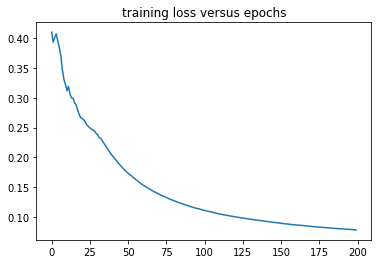

In [ ]:
plt.plot(epoch_wise_loss)
plt.title("training loss versus epochs")
plt.show()